In [72]:
from utils.cyclone_utils import get_datetime
import pandas as pd


## CYCLONE MASTER DF
cyclone_df = pd.read_csv('../cyclone_data/jtwc/cleaned/full_cleaned.csv')
cyclone_df['month'] = cyclone_df['timestamp'].apply(lambda x: get_datetime(x).month) 
cyclone_df

,timestamp,Storm ID,BASIN,Season,SEASON TC NUMBER,Latitude (degrees),Longitude (degrees),VMAX (kt),Peak VMAX (kt),ACE,Maximum 24h Intensification,Month,Tropical SST,Tropical Anomaly,Local SST,Relative SST,Saffir-Simpson Category,month
0,1982-03-14 06:00:00,1982-N-1,WP,1982.0,1.0,7.1,153.0,15.0,60.0,0.73250,15.0,3,27.237669,-0.270336,28.082220,0.844551,1,3
1,1981-10-21 06:00:00,1982-S-2,SI,1982.0,2.0,-8.0,84.6,40.0,85.0,1.18725,25.0,10,26.766030,-0.146004,28.012896,1.246866,2,10
2,1982-03-18 06:00:00,1982-N-2,WP,1982.0,2.0,3.8,160.7,25.0,105.0,2.02800,25.0,3,27.237669,-0.270336,29.003502,1.765833,3,3
3,1981-11-03 18:00:00,1982-S-3,SI,1982.0,3.0,-8.6,92.9,55.0,80.0,1.08875,15.0,11,26.829243,-0.228115,27.334639,0.505396,1,11
4,1982-03-28 06:00:00,1982-N-3,WP,1982.0,3.0,3.5,156.6,20.0,75.0,0.70650,15.0,3,27.237669,-0.270336,28.872086,1.634417,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854,2022-10-14 06:00:00,2022-N-24,WP,2022.0,24.0,26.4,154.4,25.0,40.0,0.19675,15.0,10,26.962795,0.050762,28.137896,1.175100,1,10
1855,2022-10-26 00:00:00,2022-N-26,WP,2022.0,26.0,12.2,133.8,20.0,75.0,0.67825,25.0,10,26.962795,0.050762,29.645842,2.683046,1,10
1856,2022-10-28 12:00:00,2022-N-27,WP,2022.0,27.0,8.0,140.4,25.0,40.0,0.10875,15.0,10,26.962795,0.050762,29.821840,2.859045,1,10
1857,2022-11-11 18:00:00,2022-N-28,WP,2022.0,28.0,20.2,166.3,20.0,40.0,0.10600,10.0,11,27.142609,0.085251,28.148760,1.006151,1,11


In [73]:
## Split into basins and calculate rates for each calendar month
dfs = {}
for basin_name in cyclone_df['BASIN'].unique():
    dfs[basin_name] = cyclone_df.loc[cyclone_df.loc[:, 'BASIN'] == basin_name]

## rate = mean occurrence per month....
rates = {}
basin_boundaries = {}

for basin_name in dfs.keys():
    basin_df = dfs[basin_name]
    BASIN_NUM_SEASONS = basin_df['Season'].max() - basin_df['Season'].min()
    # basin_boundaries[basin_name] = {
    #     'lat': {
    #         'min': basin_df['Latitude (degrees)'].min(),
    #         'max': basin_df['Latitude (degrees)'].max()
    #     },
    #     'lon': {
    #         'min': basin_df['Longitude (degrees)'].min(),
    #         'max': basin_df['Longitude (degrees)'].max()
    #     }
    # }

    for month in range(1,13):
        ## probably faster with groupby
        basin_month_num_cyclones = basin_df.loc[basin_df.loc[:, 'month'] == month].shape[0]
        avg_month_rate = basin_month_num_cyclones/BASIN_NUM_SEASONS
        if basin_name not in rates.keys():
            rates[basin_name] = {}
        rates[basin_name][month] = avg_month_rate
        

In [74]:
from datetime import datetime, timedelta
import numpy as np


def get_start_of_next_month(dt):
    month = dt.month
    year = dt.year
    if month == 12:
        return datetime.strptime(f'{year + 1}-01-01', "%Y-%m-%d")
    
    return datetime.strptime(f'{year}-{month + 1}-01', "%Y-%m-%d")

new_cyclones = None

for basin_name in rates.keys():
    start_time = None;
    end_time = None
    basin_df = dfs[basin_name]

    if basin_name == 'WP':
        ## should we only filter by cyclone seasons
        start_time = datetime.strptime("2015-01-01", "%Y-%m-%d")
        end_time = datetime.strptime("2050-01-01", "%Y-%m-%d")
    else:
        start_time = datetime.strptime("2015-01-01", "%Y-%m-%d")
        end_time = datetime.strptime("2050-01-01", "%Y-%m-%d")

    current_time = start_time
   
    while current_time < end_time:
        current_month = current_time.month
        current_year = current_time.year
        start_of_next_month = get_start_of_next_month(current_time)
        print('current time: ' + current_time.strftime('%Y-%m-%d'))
        current_rate = rates[basin_name][current_month]
        if current_rate == 0:
            current_time = get_start_of_next_month(current_time)
            print('no cyclones, skipping month')
        else:
            months_till_cyclone = np.random.exponential(1/current_rate)
            print(f'months till next cyclone: {months_till_cyclone}')
            delta = timedelta(days = months_till_cyclone * (365.25/12))
            time_of_start = current_time + delta
            if time_of_start > start_of_next_month:
                print('in next month, rate changes!!!')
                current_time = get_start_of_next_month(current_time)
            else:
                print('still in current month')
                time_of_start = current_time + delta
                print('genesis date: ' +  time_of_start.strftime('%Y-%m-%d'))

                ## SAMPLE ITS LOCATION AND ADD TO DATAFRAME
                ## ATM JUST UNIFORMLY...

                ## add some gaussian noise....
                # lat_noise = np.random.normal(0,1)
                # lon_noise = np.random.normal(0,2)

                coord_pairs = np.array(list(zip(basin_df['Latitude (degrees)'], basin_df['Longitude (degrees)'])))
                index = np.random.choice(coord_pairs.shape[0], 1)
                coord = coord_pairs[index][0]

                lat = coord[0]
                lon = coord[1]

                cyclone_obj = {
                    'timestamp': [datetime.strftime(time_of_start, '%Y-%m-%d')],
                    'lat': [lat],
                    'lon': [lon],
                    'BASIN': [basin_name]
                }

                print(cyclone_obj)

                new_cyclone = pd.DataFrame(cyclone_obj)
                if new_cyclones is None:
                    new_cyclones = new_cyclone
                else:
                    new_cyclones = pd.concat([new_cyclones, new_cyclone])

                # current_time += delta
                current_time = time_of_start
        

new_cyclones =  new_cyclones.sort_values(by=['timestamp'])
new_cyclones['index'] = range(new_cyclones.shape[0])
new_cyclones = new_cyclones.set_index('index')
    


current time: 2015-01-01
months till next cyclone: 5.71869432921853
in next month, rate changes!!!
current time: 2015-02-01
months till next cyclone: 3.0392807851813335
in next month, rate changes!!!
current time: 2015-03-01
months till next cyclone: 4.820418066442375
in next month, rate changes!!!
current time: 2015-04-01
months till next cyclone: 4.050358677071151
in next month, rate changes!!!
current time: 2015-05-01
months till next cyclone: 0.05791423662405773
still in current month
genesis date: 2015-05-02
{'timestamp': ['2015-05-02'], 'lat': [12.8], 'lon': [133.9], 'BASIN': ['WP']}
current time: 2015-05-02
months till next cyclone: 3.1113610385197257
in next month, rate changes!!!
current time: 2015-06-01
months till next cyclone: 1.8481577998916863
in next month, rate changes!!!
current time: 2015-07-01
months till next cyclone: 0.10301267135584166
still in current month
genesis date: 2015-07-04
{'timestamp': ['2015-07-04'], 'lat': [6.5], 'lon': [175.5], 'BASIN': ['WP']}
curre

latitude: -23.7 to 30.4
longitude: 36.9 to 228.6


/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


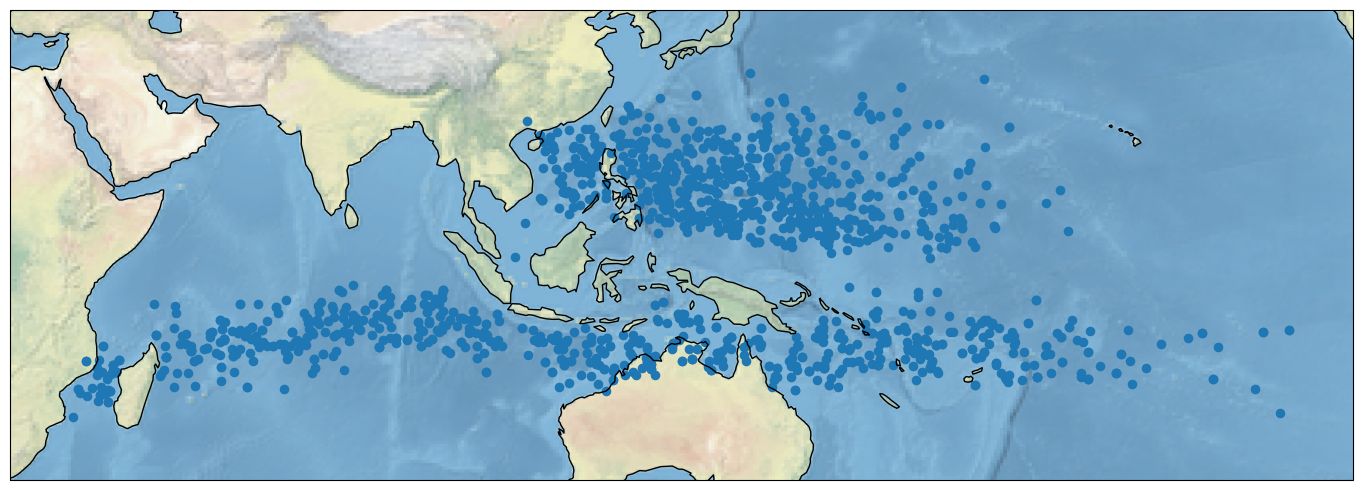

In [75]:

# %matplotlib inline
from matplotlib import pyplot as plt
import cartopy.crs as ccrs

## only show origin sites for now
min_long = new_cyclones['lon'].min()
min_lat = new_cyclones['lat'].min()

max_long = new_cyclones['lon'].max()
max_lat = new_cyclones['lat'].max()

centre_long = (max_long-min_long)/2

print('latitude: ' + str(min_lat) + ' to ' + str(max_lat))
print('longitude: ' + str(min_long) + ' to ' + str(max_long))

height = 5
fig = plt.figure(figsize=((max_long - min_long)/(max_lat-min_lat)*height, height))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude= centre_long))
ax.set_extent([min_long - 10, max_long + 10 ,min_lat - 10,max_lat + 10], ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()

scatter = plt.scatter(x=new_cyclones['lon'], y=new_cyclones['lat'], transform=ccrs.PlateCarree(), s=35)

fig.tight_layout()
plt.show()

# fig.savefig('./media/Cyclone/cyclone_map/all_cyclones.png')

In [76]:
from utils.SST_utils import get_local_smooth_at_time, sel_mm_yyyyy, get_local_mean, get_cmip_prediction, get_tropical_avg

def filter_nan_from_values(list_obj):
    if len(list_obj) == 0:
        return np.nan
    
    return list_obj[0]

new_cyclones['timestamp'] = pd.to_datetime(new_cyclones['timestamp'])
new_cyclones['timestamp'] = new_cyclones['timestamp'].apply(lambda x: str(x)) 
new_cyclones



,timestamp,lat,lon,BASIN
index,,,,
0,2015-01-02 00:00:00,-16.1,147.9,SP
1,2015-01-05 00:00:00,-12.6,121.5,SI
2,2015-01-07 00:00:00,-15.5,163.7,SP
3,2015-01-09 00:00:00,-13.5,196.8,SP
4,2015-01-09 00:00:00,-15.4,162.8,SP
...,...,...,...,...
1634,2049-11-13 00:00:00,15.4,113.0,WP
1635,2049-12-09 00:00:00,-18.7,156.0,SP
1636,2049-12-27 00:00:00,-14.6,155.6,SP


In [77]:
## create multi index...

scenarios = [126, 245, 370, 585]
new_cyclones = pd.concat([new_cyclones]*len(scenarios), keys=scenarios, names=['Scenario'], axis=0)
new_cyclones

timestamp   lat    lon BASIN
Scenario index                                        
126      0      2015-01-02 00:00:00 -16.1  147.9    SP
         1      2015-01-05 00:00:00 -12.6  121.5    SI
         2      2015-01-07 00:00:00 -15.5  163.7    SP
         3      2015-01-09 00:00:00 -13.5  196.8    SP
         4      2015-01-09 00:00:00 -15.4  162.8    SP
...                             ...   ...    ...   ...
585      1634   2049-11-13 00:00:00  15.4  113.0    WP
         1635   2049-12-09 00:00:00 -18.7  156.0    SP
         1636   2049-12-27 00:00:00 -14.6  155.6    SP
         1637   2049-12-27 00:00:00  -6.0   89.5    SI
         1638   2049-12-29 00:00:00 -10.0  228.6    SP

[6556 rows x 4 columns]

In [78]:
for scenario in scenarios:
    cmip_sst_predictions = get_cmip_prediction(scenario)
    cmip_tropical_avg = get_tropical_avg(cmip_sst_predictions)

    def curried_local_smooth(lat, lon, time):
        return get_local_smooth_at_time(cmip_sst_predictions, lat,lon, time) 

    def curried_local_mean_for_month( lat, lon, time):
        return get_local_mean(cmip_sst_predictions, lat,lon, time) 
    
    def get_tropical_average_for_month(time):
        dt_obj = datetime.strptime(time, '%Y-%m-%d %X')
        month = dt_obj.month
        year = dt_obj.year

        match = cmip_tropical_avg.sel(
            time= sel_mm_yyyyy(cmip_tropical_avg, month, year))

        try:
            return match.mean() 
        except Exception:
            return np.nan
    
    def diff(x1, x2):
        return x1 - x2
        
    
    local_smooth_vectorized = np.vectorize(curried_local_smooth)
    local_mean_for_month_vectorized = np.vectorize(curried_local_mean_for_month)
    tropical_mean_vectorized = np.vectorize(get_tropical_average_for_month)
    diff_vectorized = np.vectorize(diff)

    new_cyclones.loc[scenario,'Tropical SST'] = tropical_mean_vectorized(new_cyclones.loc[scenario,'timestamp'])
    new_cyclones.loc[scenario,'Local SST'] = local_smooth_vectorized(new_cyclones.loc[scenario,'lat'], new_cyclones.loc[scenario,'lon'], new_cyclones.loc[scenario,'timestamp'])
    new_cyclones.loc[scenario,'Relative SST'] =  diff_vectorized(new_cyclones.loc[scenario, 'Local SST'], new_cyclones.loc[scenario,'Tropical SST'])
    # ## for each scenario, positive rSST... This is another interesting thing to check...
  
# new_cyclones = new_cyclones.sort_values(by=['timestamp']).dropna(subset=['Tropical SST', 'Local SST'], how='any')

new_cyclones = new_cyclones.query('`Relative SST` > 0')
new_cyclones
## ONLY HAVE RECORD UP TO 2014

timestamp   lat    lon BASIN  Tropical SST  \
Scenario index                                                         
126      0      2015-01-02 00:00:00 -16.1  147.9    SP     27.529079   
         1      2015-01-05 00:00:00 -12.6  121.5    SI     27.529079   
         2      2015-01-07 00:00:00 -15.5  163.7    SP     27.529079   
         3      2015-01-09 00:00:00 -13.5  196.8    SP     27.529079   
         4      2015-01-09 00:00:00 -15.4  162.8    SP     27.529079   
...                             ...   ...    ...   ...           ...   
585      1632   2049-10-26 00:00:00   6.6  161.6    WP     28.425661   
         1633   2049-11-11 00:00:00  10.5  136.9    WP     28.619442   
         1636   2049-12-27 00:00:00 -14.6  155.6    SP     28.649031   
         1637   2049-12-27 00:00:00  -6.0   89.5    SI     28.649031   
         1638   2049-12-29 00:00:00 -10.0  228.6    SP     28.649031   

                Local SST  Relative SST  
Scenario index                           
126      0      29.031300      1.502220  
         1      30.160503      2.631424  
         2      29.267181      1.738102  
         3      29.602779      2.073700  
         4      29.267181      1.738102  
...                   ...           ...  
585      1632   30.963099      2.537437  
         1633   30.343124      1.723682  
         1636   29.504644      0.855614  
         1637   29.567881      0.918850  
         1638   28.880701      0.231670  

[5961 rows x 7 columns]

In [79]:
new_cyclones.to_csv('../cyclone_data/resampled/future_cyclones_cmip.csv')